### Build a content-based recommendation system using:
1. Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder-large/5
2. Annoy: https://github.com/spotify/annoy
3. imdb-movies dataset: on myCourse

In [1]:
# Install TF for Mac M1 (put in environment.yaml and update the env after)
# pip install tensorflow-macos
# pip install tensorflow-hub

In [2]:
import os
import tensorflow_hub as hub
import tensorflow as tf
from annoy import AnnoyIndex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
stop = stopwords.words('english')

import time
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s',
    level=logging.INFO
)
logger = logging.getLogger(__name__)

#### Load imdb-movies dataset from myCourse

In [3]:
BASE_DIR =  os.path.join(os.path.dirname(os.path.realpath('__file__')), 'dev-data') 

In [4]:
df = pd.read_csv(f'{BASE_DIR}/data/imdb_top_1000.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1000 non-null   float64
 1   series_title   1000 non-null   object 
 2   released_year  1000 non-null   object 
 3   certificate    899 non-null    object 
 4   runtime        1000 non-null   object 
 5   genre          1000 non-null   object 
 6   imdb_rating    1000 non-null   float64
 7   overview       1000 non-null   object 
 8   meta_score     843 non-null    float64
 9   director       1000 non-null   object 
 10  star1          1000 non-null   object 
 11  star2          1000 non-null   object 
 12  star3          1000 non-null   object 
 13  star4          1000 non-null   object 
 14  no_of_votes    1000 non-null   float64
 15  gross          832 non-null    object 
dtypes: float64(4), object(12)
memory usage: 125.5+ KB


#### Preprocessing

In [6]:
# columns subset
cols_to_keep = ['id', 'series_title', 'genre', 'imdb_rating', 'overview', 'director']
df = df[cols_to_keep]
df.head(2)

,id,series_title,genre,imdb_rating,overview,director
0,1.0,The Shawshank Redemption,Drama,9.3,Two imprisoned men bond over a number of years...,Frank Darabont
1,2.0,The Godfather,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,Francis Ford Coppola


In [7]:
# clean dataset
df.dropna(inplace=True)
for i in ['series_title', 'genre', 'overview', 'director']:
    
    df[i] = df[i].str.lower()
    df[i] = df[i].str.strip()
    
df.head(2)

,id,series_title,genre,imdb_rating,overview,director
0,1.0,the shawshank redemption,drama,9.3,two imprisoned men bond over a number of years...,frank darabont
1,2.0,the godfather,"crime, drama",9.2,an organized crime dynasty's aging patriarch t...,francis ford coppola


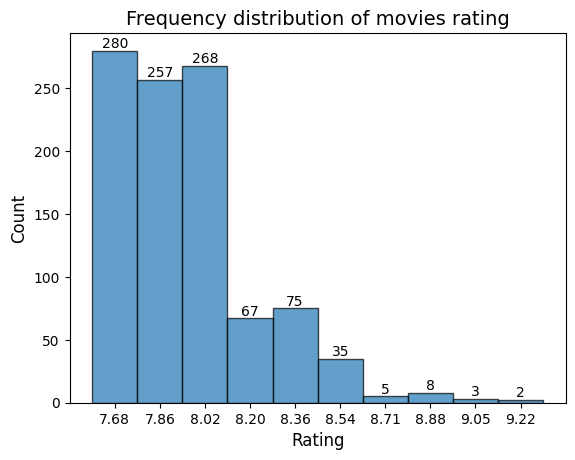

In [8]:
# Frequency distribution of movies rating

# Specify the number of bins and calculate bin edges
num_bins = 10  # You can adjust this as needed
hist, bin_edges = np.histogram(df['imdb_rating'], bins=num_bins)

# Calculate the bin widths
bin_width = bin_edges[1] - bin_edges[0]

# Calculate the bin midpoints
bin_midpoints = bin_edges[:-1] + bin_width / 2

# Create a histogram with the specified bins and widths
plt.hist(df['imdb_rating'], bins=bin_edges, width=bin_width, alpha=0.7, edgecolor='black')

# Add labels to the bars
for i in range(len(bin_edges) - 1):
    plt.text(
        bin_midpoints[i],  # x-coordinate for the label (bin midpoint)
        hist[i],  # y-coordinate for the label (height of the bar)
        str(round(hist[i])),  # Text to display (count in the bin)
        ha='center',  # Horizontal alignment
        va='bottom'  # Vertical alignment
    )

# Set the title and axis labels
plt.title('Frequency distribution of movies rating', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Set x-axis tick positions to the bin midpoints
plt.xticks(bin_midpoints, ["{:.2f}".format(round(x,2)) for x in bin_midpoints])

# Display the plot
plt.show()

In [9]:
# convert ratings into tiers
def convert_ratings_into_tiers(x):
    
    if x < 8:
        return 'tier 3'
    elif x >= 8 and x < 9:
        return 'tier 2'
    else:
        return 'tier 1'
    
df['tier'] = df['imdb_rating'].apply(lambda x: convert_ratings_into_tiers(x))

df.head(2)

,id,series_title,genre,imdb_rating,overview,director,tier
0,1.0,the shawshank redemption,drama,9.3,two imprisoned men bond over a number of years...,frank darabont,tier 1
1,2.0,the godfather,"crime, drama",9.2,an organized crime dynasty's aging patriarch t...,francis ford coppola,tier 1


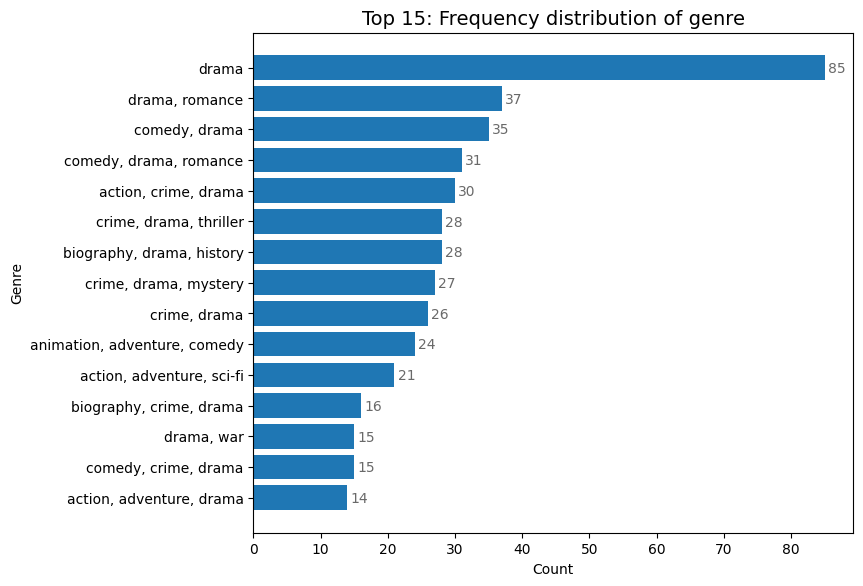

In [10]:
pop = df.groupby(['genre']).agg({
    'genre': [('count')]
})

pop.columns = pop.columns.droplevel(level=0)
pop15 = pop.sort_values(by='count', ascending=False).head(15)

fig = plt.figure(figsize=(6,5))
ax = fig.add_axes([0,0,1,1])
author = pop15.index
cnt = pop15['count']
ax.barh(author, cnt)

plt.gca().invert_yaxis()

# Set the tick locations and labels
current_values = plt.gca().get_xticks()
tick_locations = [0, 10, 20, 30, 40, 50, 60, 70, 80] 
ax.set_xticks(tick_locations)
#ax.set_xticklabels(['{:,.0f}'.format(x) for x in tick_locations])

for i, v in enumerate(cnt):
    ax.text(v + 0.5, i + .15, str(v), color='dimgray')

# Set the title and axis labels
plt.title('Top 15: Frequency distribution of genre', fontsize=14)
plt.ylabel('Genre', fontsize=10)
plt.xlabel('Count', fontsize=10)

plt.show()

In [11]:
# merge attributes
def merge_description(df, col_list):
    return df[col_list].apply(lambda x: ' '.join(x), axis=1)

cols_to_merge = ['series_title', 'genre', 'overview', 'director', 'tier']

# Just curious, if I change the order of the merge 
# the recommendation change for the last movie
# cols_to_merge = ['series_title', 'genre', 'director', 'tier', 'overview']

df = df.assign(description=lambda x: merge_description(x, cols_to_merge))

df.head(2)

,id,series_title,genre,imdb_rating,overview,director,tier,description
0,1.0,the shawshank redemption,drama,9.3,two imprisoned men bond over a number of years...,frank darabont,tier 1,the shawshank redemption drama two imprisoned ...
1,2.0,the godfather,"crime, drama",9.2,an organized crime dynasty's aging patriarch t...,francis ford coppola,tier 1,"the godfather crime, drama an organized crime ..."


In [12]:
# remove stopwords
df['description'] = df['description'].apply(lambda x: ' '.join([w for w in x.split() if w not in (stop)]))

df.head(2)

,id,series_title,genre,imdb_rating,overview,director,tier,description
0,1.0,the shawshank redemption,drama,9.3,two imprisoned men bond over a number of years...,frank darabont,tier 1,shawshank redemption drama two imprisoned men ...
1,2.0,the godfather,"crime, drama",9.2,an organized crime dynasty's aging patriarch t...,francis ford coppola,tier 1,"godfather crime, drama organized crime dynasty..."


#### Embeddings with universal-sentence-encoder-large_5

"The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

The model is trained and optimized for greater-than-word length text, such as sentences, phrases or short paragraphs. It is trained on a variety of data sources and a variety of tasks with the aim of dynamically accommodating a wide variety of natural language understanding tasks. The input is variable length English text and the output is a 512 dimensional vector. The universal-sentence-encoder-large model is trained with a Transformer encoder."

In [13]:
# only 1000 rows in our dataset
# genre is small count number (see top 15-freq of genre histogram)
# no need to pass our data in chunk by chunk for embeddings (ex: by genre)

df.shape

(1000, 8)

In [14]:
# The model has been loaded locally from the web
# https://tfhub.dev/google/universal-sentence-encoder-large/5

embed = hub.load(f'{BASE_DIR}/model/universal-sentence-encoder-large_5')

2023-09-25 17:26:38,390 : INFO : Fingerprint not found. Saved model loading will continue.


In [15]:
start = time.time()
features_1 = embed(df['description'])
print(f'Total time: {time.time() - start} sec')
print(features_1.shape)
#embeddings[0] # the dimension is 512

Total time: 3.855893850326538 sec
(1000, 512)


##### Other technique: tf.data: Build TensorFlow input pipelines
https://www.tensorflow.org/guide/data

"The tf.data API enables you to build complex input pipelines from simple, reusable pieces. The pipeline for a text model might involve extracting symbols from raw text data, converting them to embedding identifiers with a lookup table, and batching together sequences of different lengths. The tf.data API makes it possible to handle large amounts of data, read from different data formats, and perform complex transformations.

To create an input pipeline, you must start with a data source. For example, to construct a Dataset from data in memory, you can use tf.data.Dataset.from_tensors() or tf.data.Dataset.from_tensor_slices(). Once you have a Dataset object, you can transform it into a new Dataset by chaining method calls on the tf.data.Dataset object. Once you have a dataset, you can apply transformations to prepare the data for your model."

In [16]:
start = time.time()

features_2 = tf.data.Dataset.from_tensor_slices([df['description']])
features_2 = features_2.map(lambda x: embed(x))

print(f'Total time: {time.time() - start} sec')
print(features_2)

Total time: 0.6356239318847656 sec
<_MapDataset element_spec=TensorSpec(shape=(None, 512), dtype=tf.float32, name=None)>


In [17]:
features_2.element_spec.shape[1]

512

Embeddings with tf.data.Dataset and map is more fast:
- features_1: Total time: 3.58 sec
- features_2: Total time: 0.63 sec

#### Approximate Nearest Neighbors

In [18]:
# Create items dictionary
items_dict = dict(enumerate(df['id']))
items_dict = {v: k for k, v in items_dict.items()}

##### With features_1

In [19]:
# https://github.com/spotify/annoy

# Length of item vector that will be indexed
f = features_1.shape[1]

# Create Annoy index with desired dimensions
index = AnnoyIndex(f, metric='angular')

# add items to the index
for i, v in enumerate(features_1):
    
    index.add_item(i, v)

# building the index
index.build(n_trees=50)  #more accurate result if you have higher number of tree

index.save(f'{BASE_DIR}/model/movies_index_v1.ann')

True

In [20]:
annoy_index = AnnoyIndex(features_1.shape[1], 'angular')
annoy_index.load(f'{BASE_DIR}/model/movies_index_v1.ann')

True

In [21]:
def recommend(
    movie_id, 
    n_rec, 
    features,
    items_dict,
    annoy_index, 
    df
):

    """
    :return: recommendation list
    """

    # Get the index of the movie
    idx = items_dict[movie_id]

    # Find the nearest neighbors
    index_list = annoy_index.get_nns_by_item(i=idx, n=n_rec)

    # Generate top-N recommendations
    out = list()

    i = 0
    while i < n_rec:

        out.append(
                df[df.index == index_list[i]][['id', 'series_title', 'genre', 'director', 'imdb_rating']].values[0])
        i += 1

    out = pd.DataFrame(out, columns=['id', 'series_title', 'genre', 'director', 'imdb_rating'])

    return out

In [22]:
# the godfather
out = recommend(
    movie_id=2, 
    n_rec=6, 
    features=features_1, 
    items_dict=items_dict,
    annoy_index=annoy_index,
    df=df
)

out

,id,series_title,genre,director,imdb_rating
0,2.0,the godfather,"crime, drama",francis ford coppola,9.2
1,4.0,the godfather: part ii,"crime, drama",francis ford coppola,9.0
2,975.0,the godfather: part iii,"crime, drama",francis ford coppola,7.6
3,166.0,casino,"crime, drama",martin scorsese,8.2
4,528.0,the untouchables,"crime, drama, thriller",brian de palma,7.9
5,694.0,the conversation,"drama, mystery, thriller",francis ford coppola,7.8


The first line (serie title: The Godfather) is the movie the user is checking out. 
The following five lines constitute the recommendation.

##### With features_2

In [23]:
# https://github.com/spotify/annoy

# Length of item vector that will be indexed
f = features_2.element_spec.shape[1]

# Create Annoy index with desired dimensions
index = AnnoyIndex(f, metric='angular')

# add items to the index
for i, v in enumerate(next(iter(features_2.take(1)))):
#for i, v in enumerate(list(features_2)[:][0]): #work also
    
    index.add_item(i, v)

# building the index
index.build(n_trees=50)  #more accurate result if you have higher number of tree

index.save(f'{BASE_DIR}/model/movies_index_v2.ann')

True

In [24]:
annoy_index = AnnoyIndex(features_2.element_spec.shape[1], 'angular')
annoy_index.load(f'{BASE_DIR}/model/movies_index_v2.ann')

True

In [25]:
# the godfather
out = recommend(
    movie_id=2, 
    n_rec=6, 
    features=features_2, 
    items_dict=items_dict,
    annoy_index=annoy_index,
    df=df
)

out

,id,series_title,genre,director,imdb_rating
0,2.0,the godfather,"crime, drama",francis ford coppola,9.2
1,4.0,the godfather: part ii,"crime, drama",francis ford coppola,9.0
2,975.0,the godfather: part iii,"crime, drama",francis ford coppola,7.6
3,166.0,casino,"crime, drama",martin scorsese,8.2
4,528.0,the untouchables,"crime, drama, thriller",brian de palma,7.9
5,694.0,the conversation,"drama, mystery, thriller",francis ford coppola,7.8


Same results for the model created with features_1 and features 2.